## This is my attempt at implementing the RouBl algorithm using layer-wise updates

In [41]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_probability as tfp
import fannypack

from tqdm import tqdm
import pandas as pd

In [5]:
from sklearn.datasets import load_iris
import pandas as pd

# Load the Iris dataset
iris = load_iris()

# Convert to DataFrame
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# Add a binary target (setosa = 0, versicolor = 1)
df['Target'] = iris.target
df = df[df['Target'] != 2]  # Remove 'virginica' class (binary classification)

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [110]:
class MeanFieldLayer(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=1e-3):
        super(MeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.zeros(input_dim, output_dim)
        self.b_mu_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.zeros(output_dim)

        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Normal(self.w_mu_p, (0.5 * self.w_log_var_p).exp() * np.sqrt(2 / self.output_dim))

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Normal(self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.Normal(self.w_mu_q, (0.5 * self.w_log_var_q).exp())

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.Normal(self.b_mu_q, (0.5 * self.b_log_var_q).exp())

    def kl(self):
        weight_kl = torch.distributions.kl.kl_divergence(self.q_w(), self.p_w()).sum() 
        bias_kl = torch.distributions.kl.kl_divergence(self.q_b(), self.p_b()).sum()
        return weight_kl + bias_kl

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        return x @ weights + biases # (num_samples, batch_size, output_dim).



class MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        # activation=nn.LeakyReLU(negative_slope=0.01),
        activation=nn.ReLU(),
        noise_std=1.0,
    ):
        super(MeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.noise_covar = torch.eye(output_dim)*noise_std

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer(self.input_dim, self.hidden_dims[i]))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.output_dim)
                )
                self.network.append(torch.nn.Sigmoid())

            else:
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i])
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)

        # Propagate x through network
        for layer in self.network:
            x = layer(x)
        # x = torch.nn.Softmax(x,dim=1)
                
        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim
        return x
        # return x.squeeze(-1)

    def ll(self, y_obs, y_pred, num_samples=1):
        # """Computes the log likelihood of the outputs of self.forward(x) using a Bernoulli likelihood."""
        # print(y_pred.shape)
        # y_pred = y_pred.squeeze(0).squeeze(-1)
        # bernoulli = torch.distributions.Bernoulli(probs=y_pred)
        # ll_tensor = bernoulli.log_prob(y_obs).mean(0) 
        # return ll_tensor.squeeze()
        # """Computes the log likelihood of the outputs of self.forward(x)"""
        # l = torch.distributions.Categorical(probs=y_pred)
        # print(y_pred.shape)
        #  # take mean over num_samples dim, sum over batch_size dim
        # # note that after taking mean, batch_size becomes dim 0
        # return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1)).mean(0).sum(0).squeeze()
        #going to just write it in a way I know will work first.
        # print(y_pred.shape)



        # ll = torch.tensor([[0.0]])

        # for i, y in enumerate(y_pred.squeeze(0)):
        #     l = torch.distributions.Categorical(probs=y)
        #     ll += l.log_prob(y_obs[i].repeat(num_samples,1,1)).mean(0)
        # return ll.squeeze()
        l = torch.distributions.Bernoulli(probs=y_pred.squeeze())
        return l.log_prob(y_obs).mean(0).sum(0).squeeze()

    

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if isinstance(layer, MeanFieldLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl()
        return kl - exp_ll, exp_ll, kl

In [111]:
pre_train_model = MeanFieldBNN(4, [4, 4], 1, noise_std=0.5)
# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
print(pre_train_model)

opt = torch.optim.Adam(
    pre_train_model.parameters(),
    lr = 1e-2
)

MeanFieldBNN(
  (activation): ReLU()
  (network): ModuleList(
    (0): MeanFieldLayer()
    (1): ReLU()
    (2): MeanFieldLayer()
    (3): ReLU()
    (4): MeanFieldLayer()
    (5): Sigmoid()
  )
)


In [117]:
preds = pre_train_model(x_te, num_samples=500)
mean_preds = preds.mean(0)
mean_preds

tensor([[0.5775],
        [0.5793],
        [0.5757],
        [0.5776],
        [0.5738],
        [0.5756],
        [0.5754],
        [0.5786],
        [0.5756],
        [0.5757],
        [0.5756],
        [0.5759],
        [0.5774],
        [0.5742],
        [0.5771],
        [0.5752],
        [0.5795],
        [0.5783],
        [0.5768],
        [0.5772],
        [0.5764],
        [0.5756],
        [0.5757],
        [0.5752],
        [0.5782],
        [0.5744],
        [0.5760],
        [0.5759],
        [0.5762],
        [0.5796]], grad_fn=<MeanBackward1>)

100%|██████████| 1000/1000 [00:14<00:00, 68.67it/s]


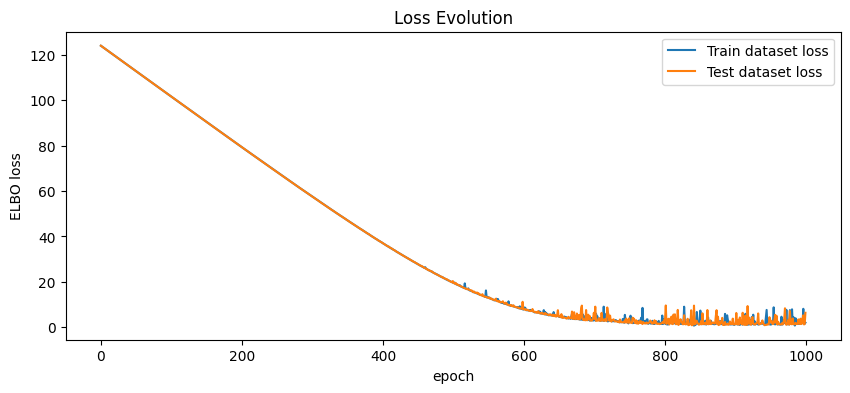

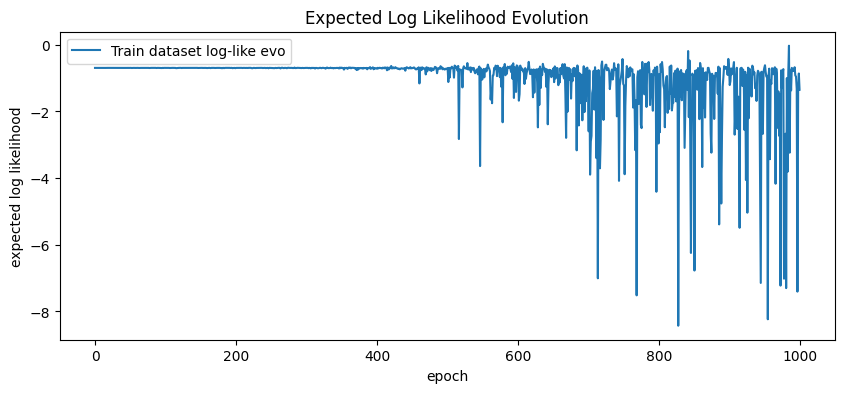

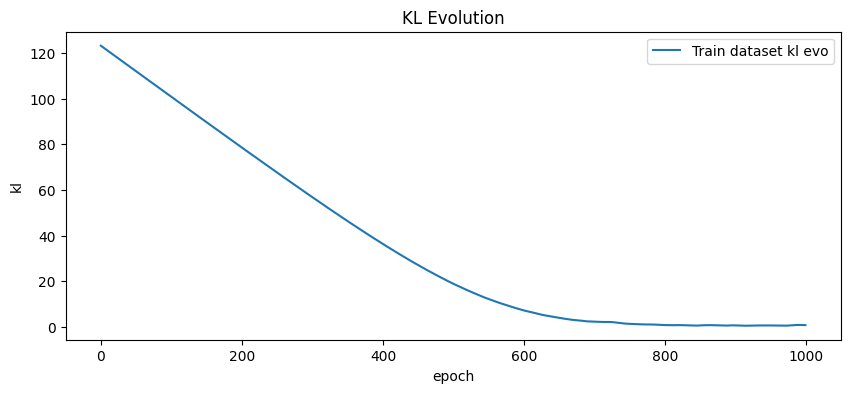

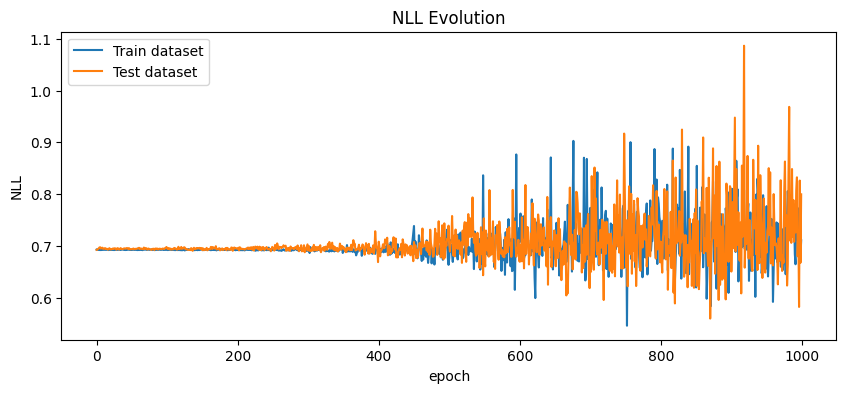

In [113]:
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []

tr_nll_loss_evo = []
te_nll_loss_evo = []
aux_loss = nn.BCELoss()
y_tr = y_tr.float()
y_te = y_te.float()
for epoch in tqdm(range(1000)):  # epochs
    opt.zero_grad()

    l, ll, kl = pre_train_model.loss(x_tr, y_tr)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_nll_loss_evo.append(aux_loss(pre_train_model(x_tr, num_samples=10).mean(0).squeeze(), y_tr).item())

    te_loss_evo.append(pre_train_model.loss(x_te, y_te)[0].item())
    te_nll_loss_evo.append(aux_loss(pre_train_model(x_te,num_samples=10).mean(0).squeeze(), y_te).item())

    l.backward()
    opt.step()

plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_nll_loss_evo, label='Train dataset')
plt.plot(te_nll_loss_evo, label='Test dataset')
plt.ylabel('NLL')
plt.xlabel('epoch')
plt.legend()
plt.title('NLL Evolution')
plt.show()

torch.int64

In [89]:
class FullCovGaussianLayer(nn.Module):
    """Represents a full covariance Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim):
        super(FullCovGaussianLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_params = input_dim * output_dim + output_dim
        # Prior parameters p(theta)
        prior_std = 0.8 ### we can later add this as a parameter
        # prior_std = 1.1 ### we can later add this as a parameter

        mu_prior = torch.ones(input_dim * output_dim + output_dim)/20 # prior mean for all weights and biases
        cov_chol_prior = torch.eye(input_dim * output_dim + output_dim,input_dim * output_dim + output_dim) * prior_std

        self.register_buffer('prior_mean', mu_prior)
        self.register_buffer('prior_weight_cov_chol', cov_chol_prior)
        self.register_buffer('prior_cov_inv', 1/prior_std**2 * torch.eye(input_dim * output_dim + output_dim,input_dim * output_dim + output_dim))  

        # initialise the trainable variational parameters for q distribution, setting them equal to the prior
        self.mean = mu_prior
        self.cov_chol = cov_chol_prior

        # initialise lambda (not sure where this is used)
        cov_chol_inv = torch.linalg.inv(self.cov_chol)
        self.lambda_1 = cov_chol_inv @ cov_chol_inv.t() @ self.mean


        # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q = dist.MultivariateNormal(self.mean, scale_tril=self.cov_chol)
        p = dist.MultivariateNormal(self.prior_mean, scale_tril=self.prior_cov_chol)
        kl = dist.kl_divergence(q, p).sum()
        return kl
    
    ## Maybe this instead wants to be in the network class and get passed to forward for each layer...might be neater
    def sample_params(self):
        # Sample from q distribution and ensure requires_grad=True
        sample = self.mean + self.cov_chol @ torch.randn_like(self.mean)
        sample = sample.detach().requires_grad_(True)  # Ensure gradients can be computed
        return sample

    def forward(self, input, sampled_params):
        """Propagates x through this layer by sampling weights from the posterior"""
        # assert (len(input.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        # assert input.shape[-1] == self.input_dim

        # num_samples = x.shape[0]

        weights = sampled_params[:self.input_dim * self.output_dim].view(self.output_dim, self.input_dim)
        biases = sampled_params[self.input_dim * self.output_dim:]
        return F.linear(input, weights, biases)
        # # rsample carries out reparameterisation trick for us   
        # weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        # biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        # return x @ weights + biases # (num_samples, batch_size, output_dim).


In [7]:
class FullCovBNN(nn.Module):
    """BNN with layer-wise block diagonal covariance Gaussian distributions."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation = nn.LeakyReLU(negative_slope=0.1),
        noise_std=1.0,
    ):
        super(FullCovBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))
    
        self.network = nn.ModuleList()

        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(FullCovGaussianLayer(self.input_dim, self.hidden_dims[i]))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    FullCovGaussianLayer(self.hidden_dims[i - 1], self.output_dim)
                )
                self.network.append(torch.nn.Sigmoid())
            else:
                self.network.append(
                    FullCovGaussianLayer(self.hidden_dims[i - 1], self.hidden_dims[i])
                )
                self.network.append(self.activation)
    
    def sample_network_params(self):
        """
        Sample parameters for each layer and store them in a dictionary.
        """
        sampled_params = {}
        for i, layer in enumerate(self.network):
            if isinstance(layer, FullCovGaussianLayer):
                # Sample params for this layer and store them
                sampled_params[i//2] = layer.sample_params()
        return sampled_params



    def forward(self, input, sampled_params):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        # Propagate x through the network with sampled parameters
        for i, layer in enumerate(self.network):
            if isinstance(layer, FullCovGaussianLayer):
                # Get the corresponding sampled parameters for this layer
                sampled_param = sampled_params[i//2]  # Divide by 2 because activations are interspersed
                # Pass input x and the sampled parameters to the layer
                input = layer(input, sampled_param)
            else:
                # Apply activation function
                input = layer(input)  # Since it's an activation function, just apply it directly

        return input


    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.Bernoulli(probs = y_pred)

        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if isinstance(layer, FullCovGaussianLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl()

        return kl - exp_ll, exp_ll, kl


In [8]:
# data (as pandas dataframes) 
X = df.drop('Target', axis=1)
y = df['Target']

In [9]:
# Convert X_encoded to a PyTorch tensor
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.to_numpy(), dtype=torch.long)

In [10]:
x_tr, x_te, y_tr, y_te = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)

In [11]:
def compute_param_gradients(net, input, targets, noise, K):
    # Initialise gradients
    gradients = {}

    # Loop through the layers in the network to initialize gradients
    for i, layer in enumerate(net.network):
        if isinstance(layer, FullCovGaussianLayer):  # Check if the layer is a FullCovGaussianLayer    
            # Initialize the gradient tensor for this layer (all zeros)
            gradients[i//2] = torch.zeros(layer.num_params, requires_grad=False) 
    for l in range(K):
        sampled_params = net.sample_network_params()  # Sample from q distribution with gradient tracking
        for param in sampled_params.values():
            if param.grad is not None:
                param.grad.zero_()

        output = net.forward(input, sampled_params)  # Forward pass

        for key, param in sampled_params.items():
            for i in range(output.shape[0]):
                output[i].backward(-targets[i]/output[i] + (1-targets[i])/(1-output[i]), retain_graph=True) ###why is this required? I feel like it shouldn't be
            gradients[key] += param.grad
            gradients[key] += net.network[key*2].prior_cov_inv @ (param - net.network[key*2].prior_mean) ##issue is that the key in a dict is a string, not a number. This is the current issue
    for key in gradients:
        gradients[key] /= K
    return gradients

In [55]:
def update_variational_params_choldate(net, input, targets, noise, K):
    gradients = compute_param_gradients(net, input, targets, noise, K) # I think this is ok but it's possible it's updating in the wrong direction
    alpha = 0.001
    gamma = 1
    
    alpha_prime = torch.tensor([1 / (1-alpha*gamma)], requires_grad=False)

    with torch.no_grad():
        for key, grad in gradients.items():
            grad = grad.unsqueeze(1)
            mu, chol = net.network[key*2].mean.unsqueeze(1), net.network[key*2].cov_chol
        
            lambda_1 = net.network[key*2].lambda_1.unsqueeze(1)

            chol_scaled = torch.sqrt(alpha_prime) * chol

            v = (chol_scaled @ (chol_scaled.t() @ grad)).squeeze()
            
            weight = - alpha / (1 + alpha * grad.t() @ v)

            print(chol_scaled.shape,v.shape,weight.shape)
            chol_updated = fannypack.utils.cholupdate(chol_scaled, v, weight)
            
        
            nu = grad.t() @ mu
            lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * grad

            net.network[key*2].lambda_1 = lambda_1.flatten()
            net.network[key*2].mean = chol_updated @ (chol_updated.t()@lambda_1).flatten() # might need to be true
            net.network[key*2].cov_chol = chol_updated # same here


In [79]:
BNN = FullCovBNN(4, [4, 4], 1, noise_std=0.15)

In [80]:
update_variational_params_choldate(BNN, x_tr, y_tr, noise=0, K=10)

torch.Size([20, 20]) torch.Size([20]) torch.Size([1])
torch.Size([20, 20]) torch.Size([20]) torch.Size([1])
torch.Size([5, 5]) torch.Size([5]) torch.Size([1])


In [81]:
BNN(x_tr,BNN.sample_network_params())

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

In [19]:
BNN = FullCovBNN(4, [4, 4], 1, noise_std=0.15)

In [22]:
BNN(x_tr,BNN.sample_network_params())

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

In [21]:
n_epochs = 1

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}')
    update_variational_params_choldate(BNN, x_tr, y_tr, 0.15, K=10)



Epoch 1


In [28]:
sampled_params = BNN.sample_network_params()  # Sample from q distribution with gradient tracking
input_data = torch.tensor(([0.25]))
BNN.forward(input_data, sampled_params)#.unsqueeze(1)
# input_data

tensor([0.1178], grad_fn=<ViewBackward0>)

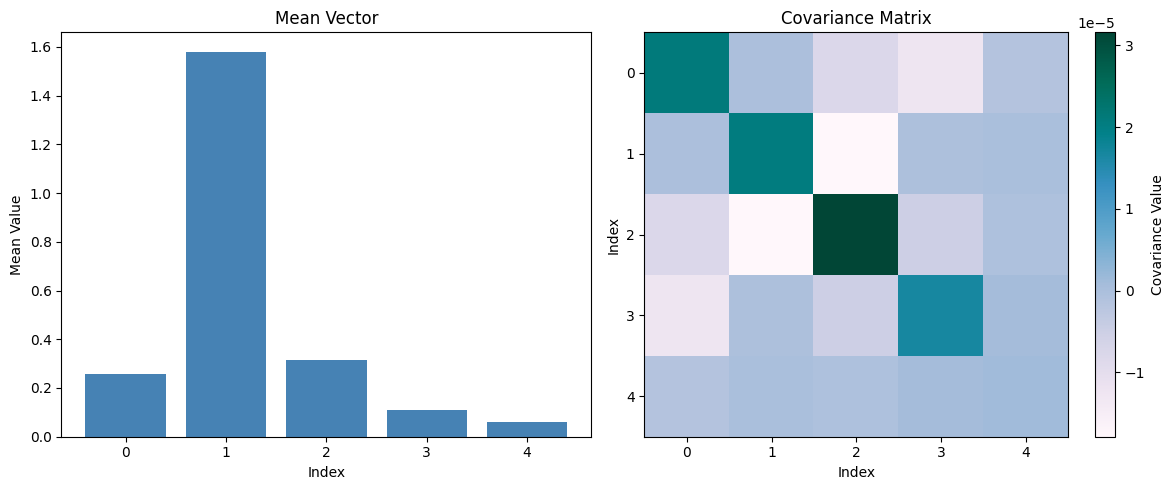

In [158]:
def plot_mean_and_covariance(BNN,layer):
    # Convert mean vector and covariance matrix to NumPy
    mean = to_numpy(BNN.network[layer].mean)
    cov = to_numpy(BNN.network[layer].cov_chol @ BNN.network[layer].cov_chol.t())

    # Create side-by-side subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot mean vector as a bar plot
    axs[0].bar(range(len(mean)), mean, color='steelblue')
    axs[0].set_title("Mean Vector")
    axs[0].set_xlabel("Index")
    axs[0].set_ylabel("Mean Value")

    # Plot covariance matrix as a heatmap
    im = axs[1].imshow(cov, cmap='PuBuGn', aspect='auto')
    axs[1].set_title("Covariance Matrix")
    axs[1].set_xlabel("Index")
    axs[1].set_ylabel("Index")
    fig.colorbar(im, ax=axs[1], label="Covariance Value")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

plot_mean_and_covariance(BNN,4)
